This is an evolving document looking at eddy tracking in support of the EXPORTS North Atlantic cruise. The goal is to estimate, from surface properties, whether or not an eddy will be retentive over a period of weeks.

To run this code you will need the files found in the Google Drive folder here: 
<https://drive.google.com/drive/folders/10Lkkelz5e3YYLz681ufuIxIhOvVwzTVT>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.interpolate import interp2d
from netCDF4 import Dataset

## Load data

First use data previously calculated by Erik Fields. Data were saved in Matlab tables and converted to .csv files. The different predictive properties used here are longitude (lon; element 4), latitude(lat; 5), time (6), area (13), eccentricity (ecc; 17), mean eddy Gamma 2 (G2; 12), mean eddy Okubo-Weiss quanitity (OW; 10), and mean eddy retentive time in days in the backward direction (RTback; 7).

In [2]:
years = [2018,2019,2020]

A_data = [np.loadtxt('eddyTables%d_anticyclonic_60d.csv'%year,delimiter=',',skiprows=1).T 
            for year in years]
C_data = [np.loadtxt('eddyTables%d_cyclonic_60d.csv'%year,    delimiter=',',skiprows=1).T 
            for year in years]
A_RT = [d[2] for d in A_data]
C_RT = [d[2] for d in C_data]
A_fracRT = [d[3] for d in A_data]
C_fracRT = [d[3] for d in C_data]
prop_names = ['lon','lat','time','area','ecc','G2','OW','RTback']
A_prop = [d[[4,5,6,13,17,12,10,7]] for d in A_data]
C_prop = [d[[4,5,6,13,17,12,10,7]] for d in C_data]

# convert from time in Matlab datetime format to time in days since April 1 (first day of analysis for each year)
A_prop = [np.vstack((prop[0:2],prop[2]-np.min(prop[2]),prop[3::])) for prop in A_prop]
C_prop = [np.vstack((prop[0:2],prop[2]-np.min(prop[2]),prop[3::])) for prop in C_prop]


Calculate the nearest anticyclonic and nearest cyclonic eddy for each of the tracked eddies (at each time step), and use these as two additional predictive parameters. This code only uses the eddies previously defined (takes a lot of computational power to go back through the raw AVISO files to find all eddies).

In [3]:
# add nearest anticyclonic and nearest cyclonic eddy to the array of properties
if True:
    A_nearestA = [[np.sort(np.sqrt((x-prop[0][prop[2]==t])**2 + (y-prop[1][prop[2]==t])**2))[1] 
                   for x,y,t in zip(prop[0],prop[1],prop[2])] 
                  for prop in A_prop]
    C_nearestC = [[np.sort(np.sqrt((x-prop[0][prop[2]==t])**2 + (y-prop[1][prop[2]==t])**2))[1] 
                   for x,y,t in zip(prop[0],prop[1],prop[2])] 
                  for prop in C_prop]
    A_nearestC = [[np.sort(np.sqrt((x-Cprop[0][Cprop[2]==t])**2 + (y-Cprop[1][Cprop[2]==t])**2))[1] 
                   for x,y,t in zip(Aprop[0],Aprop[1],Aprop[2])] 
                  for Aprop,Cprop in zip(A_prop,C_prop)]
    C_nearestA = [[np.sort(np.sqrt((x-Aprop[0][Aprop[2]==t])**2 + (y-Aprop[1][Aprop[2]==t])**2))[1] 
                   for x,y,t in zip(Cprop[0],Cprop[1],Cprop[2])] 
                  for Aprop,Cprop in zip(A_prop,C_prop)]
    
    prop_names = np.hstack((prop_names,'nearestA','nearestC'))
    A_prop = [np.vstack((prop,nearestA,nearestC)) for prop,nearestA,nearestC in zip(A_prop,A_nearestA,A_nearestC)]
    C_prop = [np.vstack((prop,nearestA,nearestC)) for prop,nearestA,nearestC in zip(C_prop,C_nearestA,C_nearestC)]

Calculate the ocean depth associated with each eddy (at each time step), using a pre-calculated bathymetric dataset (see interp_bathy.py).

In [4]:
# add bathymetry
if True:
    nc = Dataset('bathy.nc','r')
    bathy = interp2d(nc.variables['x'][:],nc.variables['y'][:],nc.variables['depth'][:])
    A_bathy = [[bathy(x,y) for x,y in zip(prop[0],prop[1])] for prop in A_prop]
    C_bathy = [[bathy(x,y) for x,y in zip(prop[0],prop[1])] for prop in C_prop]
    
    prop_names = np.hstack((prop_names,'depth'))
    A_prop = [np.vstack((prop,np.array(bathy).ravel())) for prop,bathy in zip(A_prop,A_bathy)]
    C_prop = [np.vstack((prop,np.array(bathy).ravel())) for prop,bathy in zip(C_prop,C_bathy)]

Add a fourth "year" which is just all years put together.

In [5]:
# add in the 'all' part
years = ['2018','2019','2020','all']
A_RT += (np.hstack(A_RT),)
A_fracRT += (np.hstack(A_fracRT),)
A_prop += (np.hstack(A_prop),)
C_RT += (np.hstack(C_RT),)
C_fracRT += (np.hstack(C_fracRT),)
C_prop += (np.hstack(C_prop),)


## Plot basic retention times (stuff we want to predict)

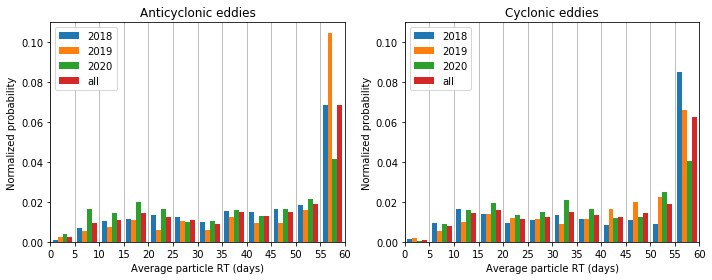

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
bins = np.arange(0,61,5)
ax[0].hist(A_RT,label=years,density=True,bins=bins)
ax[1].hist(C_RT,label=years,density=True,bins=bins)
ax[0].set_title('Anticyclonic eddies')
ax[1].set_title('Cyclonic eddies')
for a in ax:
    a.set_xlabel('Average particle RT (days)')
    a.set_xticks(bins)
    a.grid(axis='x')
    a.set_xlim(bins[[0,-1]])
    a.set_ylim([0,.11])
    a.legend(years)
    a.set_ylabel('Normalized probability')
plt.tight_layout()
plt.savefig('RTs.png',dpi=300)

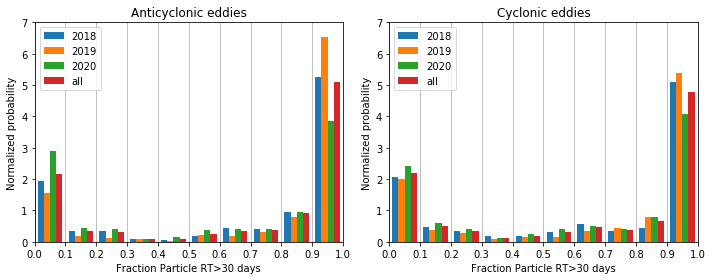

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(A_fracRT,label=years,density=True)
ax[1].hist(C_fracRT,label=years,density=True)
ax[0].set_title('Anticyclonic eddies')
ax[1].set_title('Cyclonic eddies')
for a in ax:
    a.set_xlabel('Fraction Particle RT>30 days')
    a.set_xticks(np.arange(0,1.1,.1))
    a.grid(axis='x')
    a.set_xlim([0,1])
    a.set_ylim([0,7])
    a.legend(years)
    a.set_ylabel('Normalized probability')
plt.tight_layout()
plt.savefig('fracRTs.png',dpi=300)

## Calculate correlations

In [8]:
# RT:   mean retentive time (what we want to predict)
# frac: fraction of particles with RT>30 days (also what we want to predict)
# prop: predictive properties defined above
A_coeffs = [np.corrcoef(np.vstack((RT,frac,prop))) for RT,frac,prop in zip(A_RT,A_fracRT,A_prop)]
C_coeffs = [np.corrcoef(np.vstack((RT,frac,prop))) for RT,frac,prop in zip(C_RT,C_fracRT,C_prop)]

In [9]:
A_RTmodel = [sm.OLS(RT,sm.add_constant(prop.T)).fit() for RT,prop in zip(A_RT,A_prop)]
C_RTmodel = [sm.OLS(RT,sm.add_constant(prop.T)).fit() for RT,prop in zip(C_RT,C_prop)]
A_RTmodel_rsq = [m.rsquared for m in A_RTmodel]
C_RTmodel_rsq = [m.rsquared for m in C_RTmodel]
A_RTmodel_rsqadj = [m.rsquared_adj for m in A_RTmodel]
C_RTmodel_rsqadj = [m.rsquared_adj for m in C_RTmodel]

# following lines calculate adjusted r_squared when predictive variables are sequentially removed from the regression
A_RTadjrsq_remvars = np.array([[sm.OLS(RT,sm.add_constant(np.delete(prop.T,i,axis=1))).fit().rsquared_adj 
                                for i in range(len(prop_names))]
                               for RT,prop in zip(A_RT,A_prop)])
C_RTadjrsq_remvars = np.array([[sm.OLS(RT,sm.add_constant(np.delete(prop.T,i,axis=1))).fit().rsquared_adj 
                                for i in range(len(prop_names))]
                               for RT,prop in zip(C_RT,C_prop)])

In [10]:
A_fracmodel = [sm.OLS(frac,sm.add_constant(prop.T)).fit() for frac,prop in zip(A_fracRT,A_prop)]
C_fracmodel = [sm.OLS(frac,sm.add_constant(prop.T)).fit() for frac,prop in zip(C_fracRT,C_prop)]
A_fracmodel_rsq = [m.rsquared for m in A_fracmodel]
C_fracmodel_rsq = [m.rsquared for m in C_fracmodel]
A_fracmodel_rsqadj = [m.rsquared_adj for m in A_fracmodel]
C_fracmodel_rsqadj = [m.rsquared_adj for m in C_fracmodel]

# following lines calculate adjusted r_squared when predictive variables are sequentially removed from the regression
A_fracadjrsq_remvars = np.array([[sm.OLS(RT,sm.add_constant(np.delete(prop.T,i,axis=1))).fit().rsquared_adj 
                                  for i in range(len(prop_names))]
                                 for RT,prop in zip(A_fracRT,A_prop)])
C_fracadjrsq_remvars = np.array([[sm.OLS(RT,sm.add_constant(np.delete(prop.T,i,axis=1))).fit().rsquared_adj 
                                  for i in range(len(prop_names))]
                                 for RT,prop in zip(C_fracRT,C_prop)])

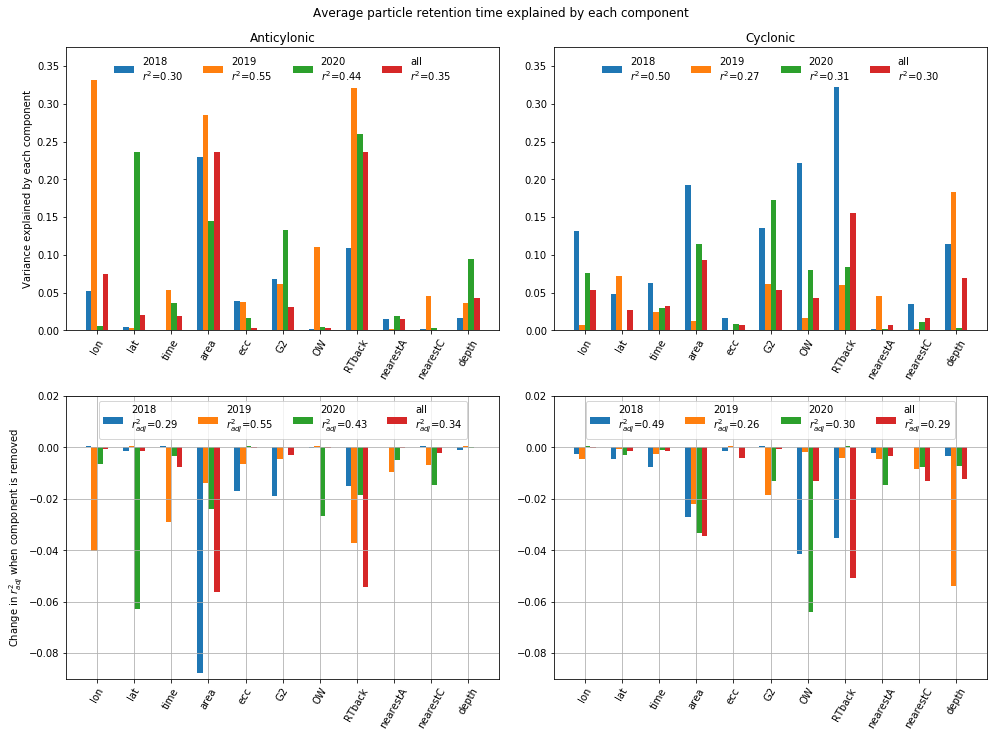

In [11]:
wid = 0.15
label1 = '%s\n$r^2$=%.2f'
label2 = '%s\n$r_{adj}^2$=%.2f'
fig,ax = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Average particle retention time explained by each component\n',va='bottom')
for i in range(4):
    ax[0,0].bar(np.arange(len(prop_names))+wid*(-1.5+i),A_coeffs[i][0][2::]**2,width=wid,label=label1%(years[i],A_RTmodel_rsq[i]))
    ax[0,1].bar(np.arange(len(prop_names))+wid*(-1.5+i),C_coeffs[i][0][2::]**2,width=wid,label=label1%(years[i],C_RTmodel_rsq[i]))
    ax[1,0].bar(np.arange(len(prop_names))+wid*(-1.5+i),A_RTadjrsq_remvars[i]-A_RTmodel_rsqadj[i],width=wid,label=label2%(years[i],A_RTmodel_rsqadj[i]))
    ax[1,1].bar(np.arange(len(prop_names))+wid*(-1.5+i),C_RTadjrsq_remvars[i]-C_RTmodel_rsqadj[i],width=wid,label=label2%(years[i],C_RTmodel_rsqadj[i]))
ax[0,0].set_title('Anticylonic')
ax[0,1].set_title('Cyclonic')
ax[0,0].set_ylabel('Variance explained by each component')
ax[1,0].set_ylabel('Change in $r_{adj}^2$ when component is removed')
for a in ax.ravel():
    a.set_xticks(np.arange(len(prop_names)))
    a.set_xticklabels(prop_names,rotation=60);
for a in ax[0]:
    a.set_ylim([0,.375])
    a.legend(ncol=4,frameon=False,loc='upper center')
for a in ax[1]:
    a.set_ylim([-.09,.02])
    a.grid(True)
    a.legend(ncol=4,loc='upper center')
plt.tight_layout()
plt.savefig('RT_predictors.png',dpi=300)

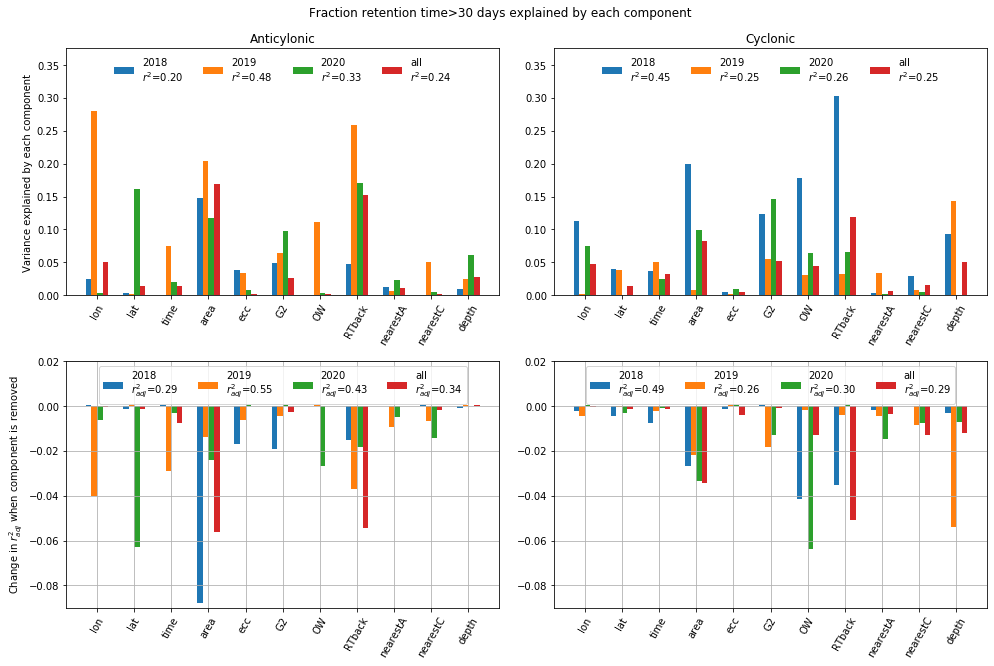

In [12]:
wid = 0.15
label1 = '%s\n$r^2$=%.2f'
label2 = '%s\n$r_{adj}^2$=%.2f'
fig,ax = plt.subplots(2,2,figsize=(14,9))
fig.suptitle('Fraction retention time>30 days explained by each component\n',va='bottom')
for i in range(4):
    ax[0,0].bar(np.arange(len(prop_names))+wid*(-1.5+i),A_coeffs[i][1][2::]**2,width=wid,label=label1%(years[i],A_fracmodel_rsq[i]))
    ax[0,1].bar(np.arange(len(prop_names))+wid*(-1.5+i),C_coeffs[i][1][2::]**2,width=wid,label=label1%(years[i],C_fracmodel_rsq[i]))
    ax[1,0].bar(np.arange(len(prop_names))+wid*(-1.5+i),A_RTadjrsq_remvars[i]-A_RTmodel_rsqadj[i],width=wid,label=label2%(years[i],A_RTmodel_rsqadj[i]))
    ax[1,1].bar(np.arange(len(prop_names))+wid*(-1.5+i),C_RTadjrsq_remvars[i]-C_RTmodel_rsqadj[i],width=wid,label=label2%(years[i],C_RTmodel_rsqadj[i]))
ax[0,0].set_title('Anticylonic')
ax[0,1].set_title('Cyclonic')
ax[0,0].set_ylabel('Variance explained by each component')
ax[1,0].set_ylabel('Change in $r_{adj}^2$ when component is removed')
for a in ax.ravel():
    a.set_xticks(np.arange(len(prop_names)))
    a.set_xticklabels(prop_names,rotation=60);
for a in ax[0]:
    a.set_ylim([0,.375])
    a.legend(ncol=4,frameon=False,loc='upper center')
for a in ax[1]:
    a.set_ylim([-.09,.02])
    a.grid(True)
    a.legend(ncol=4,loc='upper center')
plt.tight_layout()
plt.savefig('fracRT_predictors.png',dpi=300)